goal:

- use librosa on 1000 audio files and/or 50 class folders minimum
- store information in a dataframe (excluding actual file data for now)
  - folder name, file name, sampling rate, data length, file length, file size(?)

In [1]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from tqdm import tqdm
from IPython.display import Audio

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from math import floor

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# find 50 random folders

base_dir = "../datasets/birdsongs-combined/train_audio/"

folders = os.listdir(base_dir)
folders = random.sample(folders, k=50)

rows = []

# load the entire file and split the data. (interval of 10 seconds?) (remove anything that is under 10 seconds long)
split_interval_secs = 2 # change this as you please. CAN be a float i think?

for i, folder in enumerate(folders):
    folder_dir = base_dir + folder + "/"

    folder_files = 0
    for file in (progress_bar := tqdm(os.listdir(folder_dir))):
        # SET SAMPLE RATE TO 32000 FOR NOW. PREVENTS MULTIPLE STFT TRANSFORMS
        # duration might not need to be capped when using splits of X seconds
         # load AT MOST 2 minutes worth of data. purely for memory constraints. 90% of files are 2 mins or less so good cutoff point
        file_data, file_sample_rate_hz = librosa.load(folder_dir + file, sr=32000)

        total_splits = floor((len(file_data) / file_sample_rate_hz) / split_interval_secs) # floor(file length / split interval)

        #print(len(file_data) / file_sample_rate_hz, "seconds long", total_splits, "total splits")

        if total_splits >= 1:
            split_size = int(file_sample_rate_hz * split_interval_secs)

            for split_offset in range(0, file_sample_rate_hz * total_splits + 1, split_size):
                file_split_data = file_data[split_offset : split_offset + split_size]

                spec_data = np.abs(librosa.stft(file_split_data)) # convert file data into mel-spectrogram fourier transform for feeding into CNN

                row = [folder, file, len(file_split_data), file_sample_rate_hz, split_interval_secs, spec_data]
                rows.append(row)

                folder_files += 1
            
        if folder_files >= 200: break
        progress_bar.set_description(f"Folder {i + 1}/{len(folders)}* - {folder}")

    print(len(rows), "total rows")

    if len(rows) >= 2000 and i + 1 >= 25: 
        print("Enumeration ended early due to having over 2000 files and at least 10 classes.")
        break

folder_df = pd.DataFrame(data=rows, columns=["folder", "file", "samples", "sample_rate_hz", "file_length_secs", "stft_data"])

del file, folders, file_data, file_sample_rate_hz, folder, i, folder_dir, progress_bar, row, rows, spec_data # conserve memory as much as possible

Folder 1/50* - coshum: 100%|██████████| 19/19 [00:02<00:00,  6.88it/s]


191 total rows


Folder 2/50* - goowoo1:  28%|██▊       | 21/75 [00:01<00:03, 16.19it/s]


402 total rows


Folder 3/50* - olsfly:   6%|▋         | 8/125 [00:01<00:16,  7.30it/s]


609 total rows


Folder 4/50* - comior1:  11%|█         | 23/218 [00:01<00:10, 18.86it/s]


835 total rows


Folder 5/50* - grejun2:  22%|██▏       | 11/51 [00:00<00:03, 11.16it/s]


1036 total rows


Folder 6/50* - indbun:   7%|▋         | 15/207 [00:01<00:13, 14.01it/s]


1238 total rows


Folder 7/50* - blwlap1: 100%|██████████| 15/15 [00:00<00:00, 28.56it/s]


1326 total rows


Folder 8/50* - vimwea1: 100%|██████████| 18/18 [00:01<00:00, 18.00it/s]


1505 total rows


Folder 9/50* - rudpig:  16%|█▌        | 21/134 [00:01<00:06, 17.69it/s]


1705 total rows


Folder 10/50* - blknod: 100%|██████████| 14/14 [00:00<00:00, 15.12it/s]


1835 total rows


Folder 11/50* - litswi1:  13%|█▎        | 10/77 [00:01<00:07,  8.59it/s]


2084 total rows


Folder 12/50* - wynlau1: 100%|██████████| 6/6 [00:00<00:00, 11.42it/s]


2180 total rows


Folder 13/50* - webwoo1:  18%|█▊        | 22/119 [00:01<00:05, 17.57it/s]


2386 total rows


Folder 14/50* - shicow:  23%|██▎       | 22/96 [00:01<00:04, 16.04it/s]


2611 total rows


Folder 15/50* - casvir:  10%|█         | 12/118 [00:01<00:12,  8.31it/s]


2873 total rows


Folder 16/50* - phaino:  22%|██▏       | 13/60 [00:01<00:05,  8.63it/s]


3079 total rows


Folder 17/50* - pagplo:  66%|██████▌   | 35/53 [00:01<00:00, 20.96it/s]


3295 total rows


Folder 18/50* - witswa1: 100%|██████████| 5/5 [00:00<00:00, 24.38it/s]


3324 total rows


Folder 19/50* - rebfir2:  49%|████▉     | 23/47 [00:01<00:01, 21.72it/s]


3526 total rows


Folder 20/50* - sora:  14%|█▎        | 20/146 [00:01<00:07, 16.35it/s]


3737 total rows


Folder 21/50* - supsta1:  62%|██████▏   | 23/37 [00:01<00:00, 18.95it/s]


3945 total rows


Folder 22/50* - spewea1: 100%|██████████| 32/32 [00:01<00:00, 31.61it/s]


4100 total rows


Folder 23/50* - vehpar1: 100%|██████████| 36/36 [00:01<00:00, 29.80it/s]


4294 total rows


Folder 24/50* - lesyel1:  59%|█████▉    | 13/22 [00:01<00:00, 12.78it/s]


4500 total rows


Folder 25/50* - rucwar1:   5%|▍         | 8/167 [00:01<00:24,  6.39it/s]

4717 total rows
Enumeration ended early due to having over 2000 files and at least 10 classes.


In [4]:
len(folder_df["folder"].unique())

25

In [5]:
folder_df["folder"].value_counts()

folder
casvir     262
litswi1    249
comior1    226
shicow     225
rucwar1    217
pagplo     216
goowoo1    211
sora       211
supsta1    208
olsfly     207
lesyel1    206
phaino     206
webwoo1    206
rebfir2    202
indbun     202
grejun2    201
rudpig     200
vehpar1    194
coshum     191
vimwea1    179
spewea1    155
blknod     130
wynlau1     96
blwlap1     88
witswa1     29
Name: count, dtype: int64

In [6]:
mel_specs = []
mel_spec_shapes = []

for i in tqdm(folder_df.index):
    row = folder_df.iloc[i, :]

    spec_magnitude, _ = librosa.magphase(row["stft_data"])
    mel_scale_spectrogram = librosa.feature.melspectrogram(S=spec_magnitude, sr=row["sample_rate_hz"])
    mel_scale_spectrogram_db = librosa.amplitude_to_db(mel_scale_spectrogram, ref=np.min)

    mel_specs.append(mel_scale_spectrogram_db)
    mel_spec_shapes.append(mel_scale_spectrogram_db.shape)

folder_df["mel_spec"] = mel_specs
folder_df["mel_spec_shape"] = mel_spec_shapes

del mel_specs, i, row, spec_magnitude, mel_scale_spectrogram, mel_scale_spectrogram_db, mel_spec_shapes

100%|██████████| 4717/4717 [00:14<00:00, 318.59it/s]


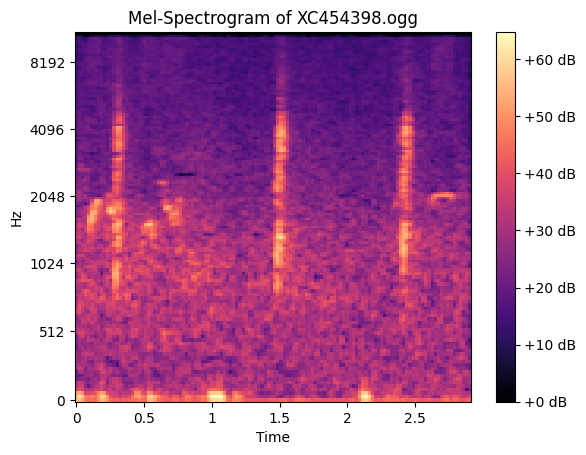

In [7]:
row = folder_df.iloc[random.randint(0, len(folder_df)), :]

plt.figure()
librosa.display.specshow(row["mel_spec"], x_axis="time", y_axis="mel")
plt.title(f"Mel-Spectrogram of {row["file"]}")
plt.colorbar(format='%+2.0f dB')
plt.show()

del row

In [8]:
# mel_spec_shape's x value is ALWAYS 128.

In [9]:
folder_df[["file_length_secs", "mel_spec_shape"]].value_counts()

# all of the same shape WHEN:
# - all file lengths are the same (customise interval at will)
# - sample rate is controlled. (e.g. 32000hz)

# 10 second file length + 32000 sampling rate = (128, 626) input shape
# 2 second file length + 32000 sampling rate = (128, 126) input shape

file_length_secs  mel_spec_shape
2                 (128, 126)        4717
Name: count, dtype: int64

In [10]:
# input shape needs to be AxBxCxD
# A = list of files
# B = depth of each one (currently just 1, as it only contains 1 value. if colours are used then maybe up it to 3)
# CxD = input width/height (128x626 etc)

x = folder_df["mel_spec"]
y = folder_df["folder"]

x = np.array([[j.tolist() for j in i] for i in x])
x = x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])
x = torch.FloatTensor(x)
x = x.to(device)

le = LabelEncoder()
y = torch.LongTensor(le.fit_transform(y))
y = y.to(device)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True, test_size=0.3, random_state=1368)

In [12]:
# create machine learning model.

class TestModel(nn.Module):
    global folder_df

    def __init__(self, input_shape: torch.Size, dropout_rate: float = 0):
        super().__init__()

        total_output_classes = len(folder_df["folder"].unique())

        # input shape should be some list/tuple of length 4
        if len(input_shape) != 4: return Exception("Input shape is not AxBxCxD.")

        # define layers here
        # assuming input shape = 1x128x126

        # conv2d: 1x128x126 -> 1x124x124 (kernel size = (5,3))
        # relu
        # max pool: 1x124x124 -> 1x62x62 (pool size = (2,2))
        # conv2d: 1x62x62 -> 1x60x60 (kernel size = (3, 3))
        # relu
        # max pool: 1x60x60 -> 1x30x30 (pool size = (2, 2))
        # flatten: 1x30x30 -> 900
        # linear: 900 -> 128
        # linear: 128 -> 32
        # linear: 32 -> (output layers)

        self.conv1 = nn.Conv2d(in_channels=input_shape[1], out_channels=1, kernel_size=(5, 3))
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.drop1 = nn.Dropout(p=dropout_rate)
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 3))
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.drop2 = nn.Dropout(p=dropout_rate)
        self.flat = nn.Flatten()
        self.linear1 = nn.Linear(in_features=900, out_features=128)
        self.linear2 = nn.Linear(in_features=128, out_features=32) 
        self.output = nn.Linear(in_features=32, out_features=total_output_classes)

    def forward(self, x):
        # define calculations here
        x = self.relu1(self.conv1(x))
        x = self.pool1(x)
        #x = self.drop1(x)
        x = self.relu2(self.conv2(x))
        x = self.pool2(x)
        #x = self.drop2(x)
        x = self.flat(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.output(x)

        return x

In [13]:
def train_model(model, loss_fn, optimizer, epochs, batch_size):
    batch_indices = np.linspace(0, len(x_train), int(len(x_train) / batch_size), dtype="int")

    train_loss_hist = []
    train_acc_hist = []
    test_acc_hist = []

    for epoch in range(1, epochs + 1):
        model.train()

        train_acc = 0
        
        for i in range(len(batch_indices) - 1):
            start_index = batch_indices[i]
            stop_index = batch_indices[i + 1]

            x_batch = x_train[start_index:stop_index]
            y_batch = y_train[start_index:stop_index]

            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            train_acc += sum(torch.argmax(y_pred, dim=1) == y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_acc = train_acc * 100 / len(y_train)

        model.eval()
        test_acc = sum(torch.argmax(model(x_test), dim=1) == y_test) * 100 / len(y_test)

        print(f"Epoch {epoch}: train loss = {loss:.04f}, train acc = {train_acc:.02f}%, test acc = {test_acc:.02f}%")

        train_loss_hist.append(float(loss.cpu().detach().numpy()))
        train_acc_hist.append(float(train_acc.cpu().detach().numpy()))
        test_acc_hist.append(float(test_acc.cpu().detach().numpy()))

    print(model)

    plt.figure(figsize=(12,8))
    pd.Series(train_acc_hist).plot.line(label="Train", color="blue")
    pd.Series(test_acc_hist).plot.line(label="Test", color="red")
    plt.legend()
    plt.ylim((0, 100))
    plt.yticks(np.arange(0, 101, 10))
    plt.title(f"Convolutional Neural Network on {len(folder_df)} files over {len(folder_df["folder"].unique())} folders.")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.grid(axis="y")
    plt.show()

    return train_loss_hist, train_acc_hist, test_acc_hist

Epoch 1: train loss = 3.2012, train acc = 3.64%, test acc = 3.88%
Epoch 2: train loss = 3.1932, train acc = 3.60%, test acc = 3.81%
Epoch 3: train loss = 3.1851, train acc = 3.73%, test acc = 4.03%
Epoch 4: train loss = 3.1714, train acc = 4.03%, test acc = 4.17%
Epoch 5: train loss = 3.1596, train acc = 3.88%, test acc = 4.24%
Epoch 6: train loss = 3.1483, train acc = 4.21%, test acc = 3.81%
Epoch 7: train loss = 3.1422, train acc = 4.60%, test acc = 3.88%
Epoch 8: train loss = 3.1366, train acc = 4.94%, test acc = 3.39%
Epoch 9: train loss = 3.1313, train acc = 5.30%, test acc = 3.53%
Epoch 10: train loss = 3.1274, train acc = 5.39%, test acc = 3.95%
Epoch 11: train loss = 3.1244, train acc = 5.39%, test acc = 3.88%
Epoch 12: train loss = 3.1217, train acc = 5.51%, test acc = 4.17%
Epoch 13: train loss = 3.1190, train acc = 5.39%, test acc = 4.10%
Epoch 14: train loss = 3.1165, train acc = 5.30%, test acc = 4.80%
Epoch 15: train loss = 3.1140, train acc = 5.45%, test acc = 4.80%
Epoc

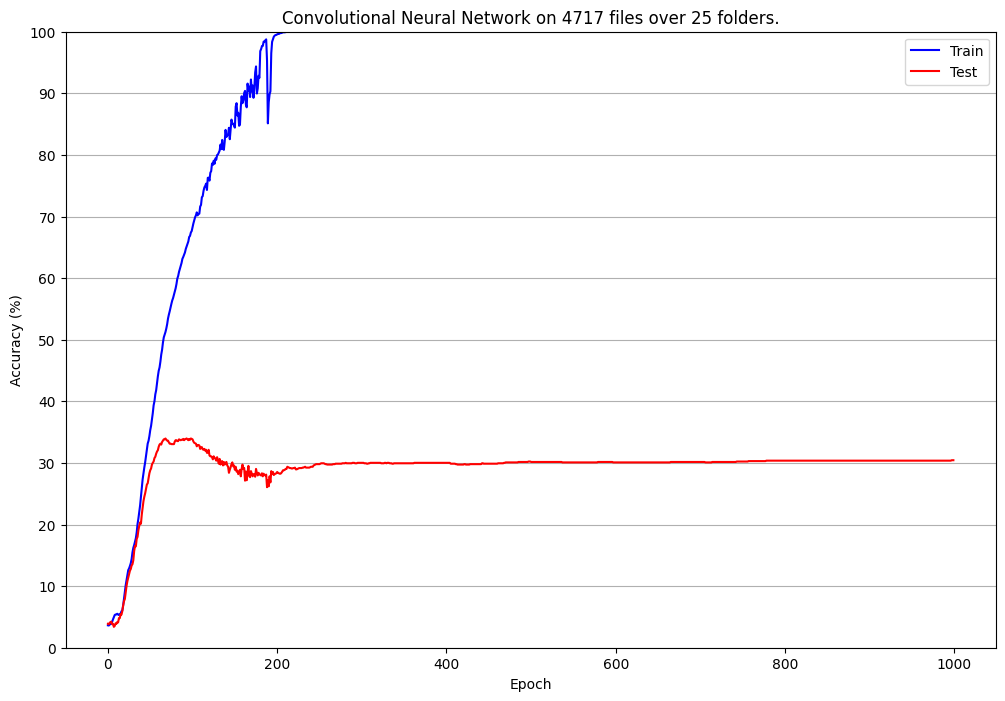

([3.2011539936065674,
  3.19321870803833,
  3.185115098953247,
  3.171428680419922,
  3.1596295833587646,
  3.1483426094055176,
  3.1422393321990967,
  3.136558771133423,
  3.1312756538391113,
  3.1274032592773438,
  3.1244056224823,
  3.1216933727264404,
  3.118964433670044,
  3.1165096759796143,
  3.1139872074127197,
  3.112031936645508,
  3.109464168548584,
  3.1071717739105225,
  3.10491681098938,
  3.10184645652771,
  3.0980100631713867,
  3.093885898590088,
  3.0880818367004395,
  3.080988645553589,
  3.071202278137207,
  3.0591042041778564,
  3.0429985523223877,
  3.021996259689331,
  2.9984071254730225,
  2.9710984230041504,
  2.9402027130126953,
  2.908313035964966,
  2.8750197887420654,
  2.846860885620117,
  2.819199323654175,
  2.7892937660217285,
  2.7570648193359375,
  2.725374221801758,
  2.6983532905578613,
  2.6704468727111816,
  2.645888566970825,
  2.6186957359313965,
  2.5914883613586426,
  2.5655410289764404,
  2.5400264263153076,
  2.515026569366455,
  2.490849256

In [18]:
# to avoid extreme overfitting:
# - dropout rate between 0.2-0.5 seems good
# - learning rate around 0.001 provides best training rate without overfitting
# - train in larger batches, 64 upwards seems good
# - most seem to plateau around 200 epochs, maybe reduce to reduce total training time

epochs = 1000
batch_size = 64
dropout_rate = 0.5
learning_rate = 0.001
momentum = 0

model = TestModel(input_shape=x.shape, dropout_rate=dropout_rate)
model = model.to(device)
loss_fn = nn.CrossEntropyLoss() # since we are classifying.
loss_fn = loss_fn.to(device)
optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate, momentum=momentum)

train_model(model, loss_fn, optimizer, epochs, batch_size)

In [15]:
# final results after testing approx. 30 different variations of dropout, learning rate, etc
# best learning rate = 0.001, batch size of 32/64, dropout rate around 0.2-0.5
# 200 epochs gives best results as test acc plateaus after that, prevents overfitting
# train/test split between 20-30% gives good results